In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/makan-siang-gratis-tweet/makan-siang-gratis-re.csv
/kaggle/input/makan-siang-gratis-tweet/makan-siang-gratis.csv
/kaggle/input/lda-dataset/predicted-sentiment.csv
/kaggle/input/gemastik-analysis/gemastik-analysis.csv
/kaggle/input/anak-stunting/anak-stunting-cleaned.csv
/kaggle/input/anak-stunting-labelled/output_with_sentiment.csv
/kaggle/input/latest-stunting-x/6k-12k.csv.xls
/kaggle/input/latest-stunting-x/pake_test_ini.csv
/kaggle/input/latest-stunting-x/train.csv


In [2]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2024-06-26 12:00:36.662620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 12:00:36.662726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 12:00:36.800903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available


In [3]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:0000:01


# **Model Training**

In [4]:
train_data = pd.read_csv('/kaggle/input/latest-stunting-x/6k-12k.csv.xls')
train_data

,full_text,sentiment_label
0,#Stunting #PencegahanStunting #TipsPerawatanBa...,neutral
1,Kepala BPIP Yudian Wahyudi dalam sambutannya m...,neutral
2,Para KPM yang sudah mendapatkan pelatihan memi...,positive
3,Strategi Pemprov Sulsel Hadapi Tantangan Stunt...,neutral
4,Kabupaten Blora Gelar Gerakan Sedekah Telur un...,positive
...,...,...
5402,@mamagemoybiasa Kalo makanan tujuan pencegahan...,negative
5403,@bantengdongok @IrawanRommi @ZHIC0 Wkwwkkwkkk....,negative
5404,Tujuan khusus kegiatan ini yaitu mengingkatkan...,neutral
5405,Dindik Kota Kediri Gelar Workshop Intervensi S...,neutral


In [5]:
train_data = train_data[train_data['sentiment_label'] != 'neutral ']

In [6]:
print(train_data['sentiment_label'].unique())
print(train_data['sentiment_label'].value_counts())

['neutral' 'positive' 'negative']
sentiment_label
neutral     3216
negative    1518
positive     672
Name: count, dtype: int64


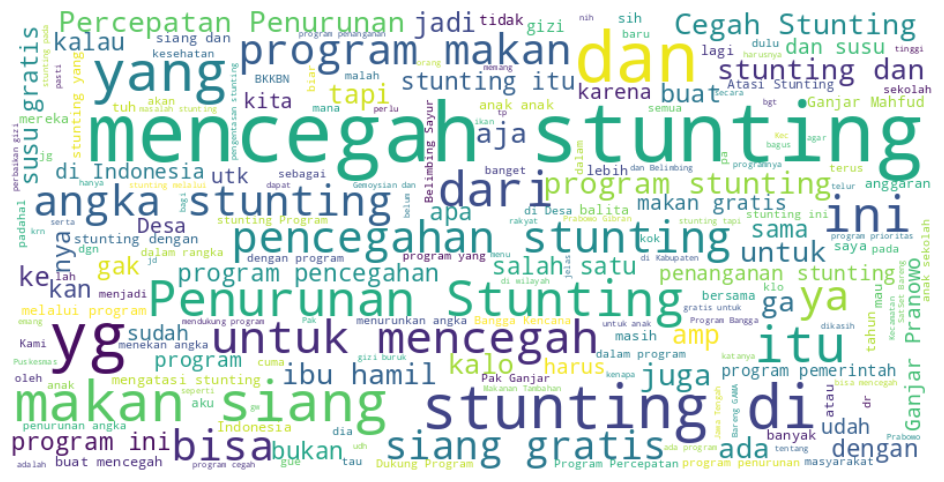

In [7]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

all_text = " ".join(review for review in train_data['full_text'])

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

plt.figure(figsize=(16, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

custom_stopwords = ["nya", "yg", "jg", 'aja', 'utk', 'di', 'dgn', 'tp', 'lah', 'jd', 'udh', 'pa', 'amp', 'bgt', 'krn'
                   'tuh', 'kan', 'krn', 'klo', 'sih', 'apa', 'yang', 'kalo', 'biar', 'untuk', 'dr', 'juga', 'itu', 'si', 'tau'
                   'yang', 'kok', 'ada','nih', 'doang', 'gitu', 'udah', 'tuh', 'ini', 'pas', 'jadi', 'tu', 'sdh', 'trs', 'kek',
                   'melalui', 'buat' 'kalau', 'yes', 'nah', 'kalau', 'pake', 'buat', 'dulu', 'gpmmd', 'gpmmd 4palu', 'gpmmd 4donggala'
                   'carafitnahkelautaja', 'masbowogibran', '4donggala', '4palu', 'dg', 'loh', '4kupang', 'mah', 'gini', 'kl', 'deh', '4kupang']

def preprocess_text(text, custom_stopwords):
    # Ensure text is stripped and extra spaces are removed
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove punctuation and lowercase text
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Change 'ga' and 'gak' to 'tidak'
    text = re.sub(r'\btdk\b', 'tidak', text)
    text = re.sub(r'\bngga\b', 'tidak', text)
    text = re.sub(r'\bgk\b', 'tidak', text) 
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    # Remove Sastrawi stopwords
    text = stopword_remover.remove(text)
    # Remove custom stopwords
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

def clean_tweet(tweet):
    # Replace URLs with a common token
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Replace mentions with a common token
    #tweet = re.sub(r'@\w+', '@USER', tweet)
    # Optionally normalize hashtags (comment out if you want to keep them as is)
    #tweet = re.sub(r'#\w+', '#HASHTAG', tweet)
    # Remove special characters and extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

emojis = {':)': 'senyum', ':-)': 'senyum', ';d': 'mengedipkan mata', ':-E': 'vampir', ':(': 'sedih', 
          ':-(': 'sedih', ':-<': 'sedih', ':P': 'meledek', ':O': 'kaget',
          ':-@': 'kaget', ':@': 'kaget',':-$': 'bingung', ':\\': 'kesal', 
          ':#': 'diam', ':X': 'diam', ':^)': 'senyum', ':-&': 'bingung', '$_$': 'rakus',
          ':-!': 'bingung', ':-D': 'senyum', ':-0': 'berteriak', 'O.o': 'bingung',
          '<(-_-)>': 'robot', 'd[-_-]b': 'ok', ';)': 'mengedipkan mata', 
          ';-)': 'mengedipkan mata',}

def replace_emojis(tweet):
    for emoji, replacement in emojis.items():
        tweet = tweet.replace(emoji, replacement)
    return tweet

def lower_case(text):  
    text = text.lower()
    return text

In [9]:
train_data['full_text'] = train_data['full_text'].apply(clean_tweet)
train_data['full_text'] = train_data['full_text'].apply(lambda x: preprocess_text(x, custom_stopwords))
train_data['full_text'] = train_data['full_text'].apply(replace_emojis)
train_data['full_text'] = train_data['full_text'].apply(lower_case)

/tmp/ipykernel_34/4169373237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['full_text'] = train_data['full_text'].apply(clean_tweet)
/tmp/ipykernel_34/4169373237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['full_text'] = train_data['full_text'].apply(lambda x: preprocess_text(x, custom_stopwords))
/tmp/ipykernel_34/4169373237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

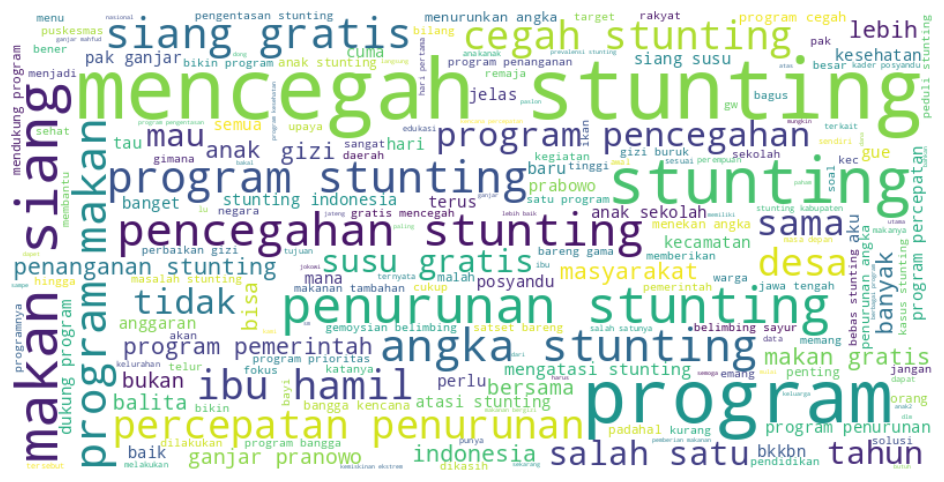

In [10]:
all_text = " ".join(review for review in train_data['full_text'])

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

plt.figure(figsize=(16, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
wc_list = ['stunting', 'mencegah stunting', 'pencegahan stunting', 'penurunan', 'penanganan', 'indonesia', 'atasi', 'cegah', 'stunting indonesia',
          'program stunting', 'salah satu', 'penurunan stunting', 'melalui program', 'program', 'mencegah', 'anak', 'anakanak', 'pak ganjar', 'ganjar pranowo', 'ganjar',
          'pranowo', 'pak', "saya", 'gua', 'gw', 'aku', 'lu', 'sy', 'gue', 'semua', 'sama', 'cuma' 'salah satu', 'salah', 'satu', 'gw', 'bagus',
          'ganjar pranowo', 'bukan', 'banget', 'pencegahan', 'prabowo', 'carafitnahkelautaja', 'efekdahsyat makangratis', 'efekdahsyat', 'ganjarmahfud',
          'emg', 'punya', 'ganjarpranowo', 'cuma', 'upaya', 'menurunkan angka', 'menurunkan', 'angka', 'sangat', 'baik', 'menekan angka', 'lebih baik',
          'ganjarmahfud2024', 'mahfud md', 'mahfud', 'md', 'emang', 'banyak',  '3mandatganjarmahfud l3bihbaik', 'mau', 'gizi', 'lebih', '3mandatganjarmahfud',
          'l3bihbaik', 'dulujokowisekarangganjar coblos3', 'dulujokowisekarangganjar', 'coblos3', 'coblos3 sukses', 'ganjarmahfudm3nangdebat']

def preprocess_wc(text, custom_stopwords):
    # Ensure text is stripped and extra spaces are removed
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove punctuation and lowercase text
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Change 'ga' and 'gak' to 'tidak'
    text = re.sub(r'\btdk\b', 'tidak', text)
    text = re.sub(r'\bngga\b', 'tidak', text)
    text = re.sub(r'\bgk\b', 'tidak', text) 
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    # Remove Sastrawi stopwords
    text = stopword_remover.remove(text)
    # Remove custom stopwords
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

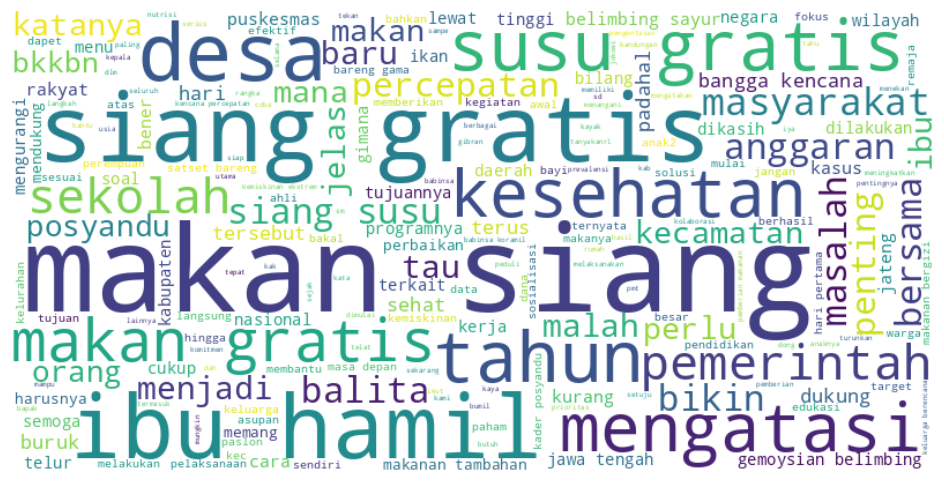

In [12]:
wc_text = train_data['full_text'].apply(lambda x: preprocess_wc(x, wc_list))

all_text = " ".join(review for review in wc_text)

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

plt.figure(figsize=(16, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Encoding**

In [13]:
label_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
train_data['sentiment_label'] = train_data['sentiment_label'].map(label_mapping)
train_data

/tmp/ipykernel_34/2556298546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sentiment_label'] = train_data['sentiment_label'].map(label_mapping)


,full_text,sentiment_label
0,stunting pencegahanstunting tipsperawatanbayi ...,0
1,kepala bpip yudian wahyudi sambutannya mendoro...,0
2,kpm sudah mendapatkan pelatihan memiliki peran...,2
3,strategi pemprov sulsel hadapi tantangan stunt...,0
4,kabupaten blora gelar gerakan sedekah telur ce...,2
...,...,...
5402,mamagemoybiasa makanan tujuan pencegahan stunt...,1
5403,bantengdongok irawanrommi zhic0 wkwwkkwkkk pro...,1
5404,tujuan khusus kegiatan yaitu mengingkatkan pen...,0
5405,dindik kota kediri gelar workshop intervensi s...,0


In [14]:
#from sklearn.utils import resample

"""
class_counts = train_data['sentiment_label'].value_counts()
minority_class_count = class_counts.min()

# Separate majority and minority classes
df_majority = train_data[train_data['sentiment_label'] == class_counts.idxmax()]
df_minority = train_data[train_data['sentiment_label'] != class_counts.idxmax()]

# Downsample majority class
df_majority_downsampled = resample(
    df_majority, 
    replace=False,
    n_samples=minority_class_count,
    random_state=42
)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify new class distribution
print(f"Balanced class distribution: {df_balanced['sentiment_label'].value_counts()}")
"""

'\nclass_counts = train_data[\'sentiment_label\'].value_counts()\nminority_class_count = class_counts.min()\n\n# Separate majority and minority classes\ndf_majority = train_data[train_data[\'sentiment_label\'] == class_counts.idxmax()]\ndf_minority = train_data[train_data[\'sentiment_label\'] != class_counts.idxmax()]\n\n# Downsample majority class\ndf_majority_downsampled = resample(\n    df_majority, \n    replace=False,\n    n_samples=minority_class_count,\n    random_state=42\n)\n\n# Combine minority class with downsampled majority class\ndf_balanced = pd.concat([df_majority_downsampled, df_minority])\ndf_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)\n\n# Verify new class distribution\nprint(f"Balanced class distribution: {df_balanced[\'sentiment_label\'].value_counts()}")\n'

In [15]:
train_data.to_csv('preprocessed_data.csv')

## **Train, Test, Val Split**

In [16]:
from sklearn.model_selection import train_test_split
import torch

y = train_data['sentiment_label']

train_df, temp_df = train_test_split(train_data, test_size=0.3, random_state=42, stratify=y)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['sentiment_label'])

In [17]:
train_data['sentiment_label'].value_counts()

sentiment_label
0    3216
1    1518
2     672
Name: count, dtype: int64

## **Tokenization**

In [18]:
from transformers import AutoTokenizer, AutoModel, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset, Dataset

tokenizer = AutoTokenizer.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [19]:
def tokenize_data(data, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

In [20]:
train_inputs, train_masks = tokenize_data(train_df['full_text'].values, tokenizer)
val_inputs, val_masks = tokenize_data(val_df['full_text'].values, tokenizer)
test_inputs, test_masks = tokenize_data(test_df['full_text'].values, tokenizer)

train_labels = torch.tensor(train_df['sentiment_label'].values, dtype=torch.long)
val_labels = torch.tensor(val_df['sentiment_label'].values, dtype=torch.long)
test_labels = torch.tensor(test_df['sentiment_label'].values, dtype=torch.long)

In [21]:
type(train_df['sentiment_label'])

pandas.core.series.Series

## **Data Loader**

In [22]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

batch_size = 20

#Train Dataset
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#Validation Dataset
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

#Test Dataset
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## **RoBERTA LSTM Model**

In [26]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, bert_model, lstm_hidden_dim, output_dim, dropout_prob, fc_dim):
        super(SentimentLSTM, self).__init__()
        self.roberta = roberta_model
        self.lstm = nn.LSTM(self.roberta.config.hidden_size, lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(lstm_hidden_dim * 2, fc_dim)
        self.fc2 = nn.Linear(fc_dim, output_dim)

    def forward(self, input_ids, attention_mask):
            with torch.no_grad():
                outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
                token_embeddings = outputs.last_hidden_state

            lstm_out, _ = self.lstm(token_embeddings)
            lstm_out = self.dropout(lstm_out)

            fc_out = self.fc(lstm_out[:, -1, :])
            fc_out = torch.relu(fc_out)
            output = self.fc2(fc_out)

            return output

roberta_model = AutoModel.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")

lstm_hidden_dim = 768
output_dim = 3  
dropout_prob = 0.35
fc_dim = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(roberta_model, lstm_hidden_dim, output_dim, dropout_prob, fc_dim)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at w11wo/indonesian-roberta-base-sentiment-classifier and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SentimentLSTM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## **Training**

In [27]:
class_counts = train_df['sentiment_label'].value_counts().sort_index()
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights.values, dtype=torch.float).to(device)

print("Class counts:", class_counts.to_dict())
print("Class weights:", class_weights.cpu().numpy())

Class counts: {0: 2251, 1: 1063, 2: 470}
Class weights: [0.12647097 0.26781386 0.60571516]


In [28]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import LinearLR

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0.05)

warmup_epochs = 3
total_epochs = 100
scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=0, total_iters=total_epochs)

criterion = CrossEntropyLoss()

# Training function
def train_model(model, train_dataloader, val_dataloader, epochs=50):
    training_stats = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            outputs = model(b_input_ids, b_input_mask)
            loss = criterion(outputs, b_labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}, Training loss: {avg_train_loss}")

        model.eval()
        total_eval_loss = 0
        total_eval_accuracy = 0

        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)

            loss = criterion(outputs, b_labels)
            total_eval_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).flatten()
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            total_eval_accuracy += accuracy

        avg_val_loss = total_eval_loss / len(val_dataloader)
        avg_val_accuracy = total_eval_accuracy / len(val_dataloader)

        print(f"Epoch {epoch+1}, Validation loss: {avg_val_loss}, Validation accuracy: {avg_val_accuracy}")
    
        training_stats['train_loss'].append(avg_train_loss)
        training_stats['val_loss'].append(avg_val_loss)
        training_stats['val_accuracy'].append(avg_val_accuracy)
        
        # Step the scheduler
        scheduler.step()

    return training_stats

# Train the model
training_stats = train_model(model, train_dataloader, val_dataloader)

Epoch 1, Training loss: 0.9538191908284237
Epoch 1, Validation loss: 0.7858185462835359, Validation accuracy: 79.77827050997783
Epoch 2, Training loss: 0.7113688470501649
Epoch 2, Validation loss: 0.6052800569592452, Validation accuracy: 79.29046563192905
Epoch 3, Training loss: 0.5959838818562658
Epoch 3, Validation loss: 0.5320009091278401, Validation accuracy: 79.53436807095343
Epoch 4, Training loss: 0.536396717789926
Epoch 4, Validation loss: 0.48895748504778236, Validation accuracy: 81.97339246119734
Epoch 5, Training loss: 0.5104859773265688
Epoch 5, Validation loss: 0.4622552482093253, Validation accuracy: 81.97339246119734
Epoch 6, Training loss: 0.49351016855553576
Epoch 6, Validation loss: 0.44512373681475476, Validation accuracy: 82.9490022172949
Epoch 7, Training loss: 0.48101024831596173
Epoch 7, Validation loss: 0.43382357606073707, Validation accuracy: 83.31485587583148
Epoch 8, Training loss: 0.47037839748357474
Epoch 8, Validation loss: 0.4260751906691528, Validation 

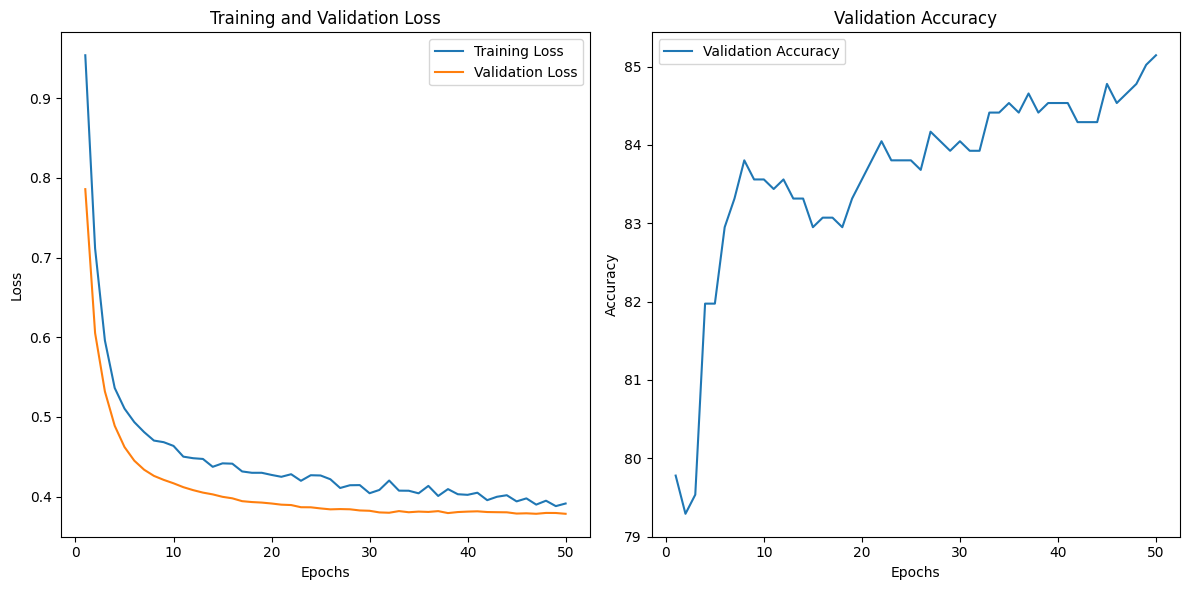

In [29]:
def plot_learning_curve(training_stats):
    epochs = range(1, len(training_stats['train_loss']) + 1)
    
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_stats['train_loss'], label='Training Loss')
    plt.plot(epochs, training_stats['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_stats['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the learning curve
plot_learning_curve(training_stats)

## **Model Evaluation**

Test loss: 0.33303311939646557, Test accuracy: 85.60975609756098, F1 score: 0.8558215649121519


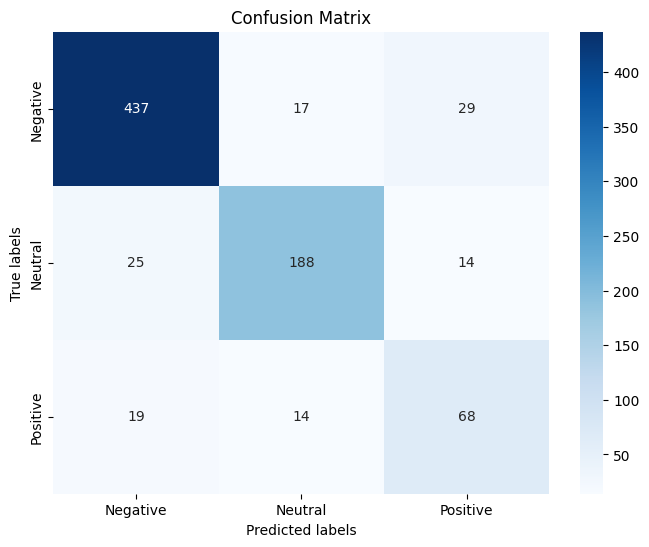

In [31]:
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_dataloader):
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0

    criterion = CrossEntropyLoss()
    
    all_preds = []
    all_labels = []

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(b_input_ids, b_input_mask)

        loss = criterion(outputs, b_labels)
        total_test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        total_test_accuracy += accuracy

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print evaluation metrics
    print(f"Test loss: {avg_test_loss}, Test accuracy: {avg_test_accuracy}, F1 score: {f1}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return avg_test_loss, avg_test_accuracy, f1

avg_test_loss, avg_test_accuracy, f1 = evaluate_model(model, test_dataloader)

In [32]:
model_save_path = 'roberta-lstm6.pth'
torch.save(model, model_save_path)

# **Predictions**

In [33]:
df = pd.read_csv('/kaggle/input/anak-stunting/anak-stunting-cleaned.csv')
text_df = df['full_text']

text_df.head(10)

0    @tanyakanrl Halo semuanya. Kami memiliki proje...
1     Gerakan Bapak Asuh Anak Stunting Dandim 1418/...
2    Kolaborasi 3 Pilar Memberikan Bantuan Kepada A...
3    Permasalahan stunting terjadi mulai dari dalam...
4    1. Stunting hingga kini masih menjadi masalah ...
5    Menyerahkan program bantuan pangan protein ber...
6    Bhabinkamtibmas Polsek Pitu Desa Pitu memberik...
7    Kodim 1013/Mtw Beri Bantuan Anak-Anak Penderit...
8    Kanitbinpolmas Polres Kulonprogo Ipda Suryanti...
9    Mbak Yuyun Aniatul Farah ini salah satu kader ...
Name: full_text, dtype: object

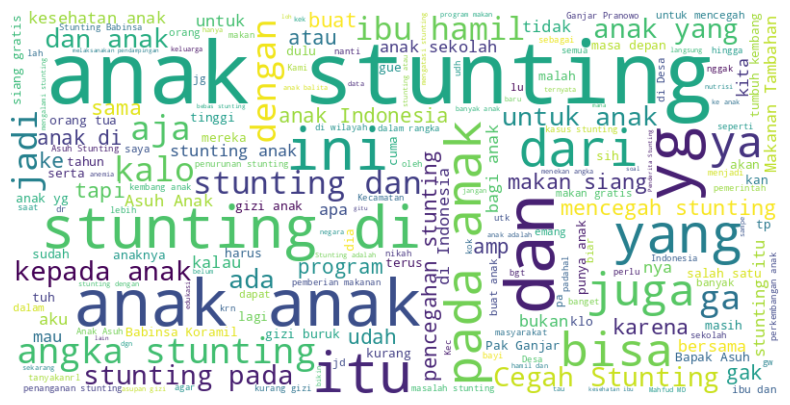

In [34]:
from wordcloud import WordCloud

all_text = " ".join(tweet for tweet in text_df)

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [35]:
df_cleaned = text_df.apply(clean_tweet)
df_cleaned = df_cleaned.apply(lambda x: preprocess_text(x, custom_stopwords))
df_cleaned = df_cleaned.apply(replace_emojis)
df_cleaned = df_cleaned.apply(lower_case)

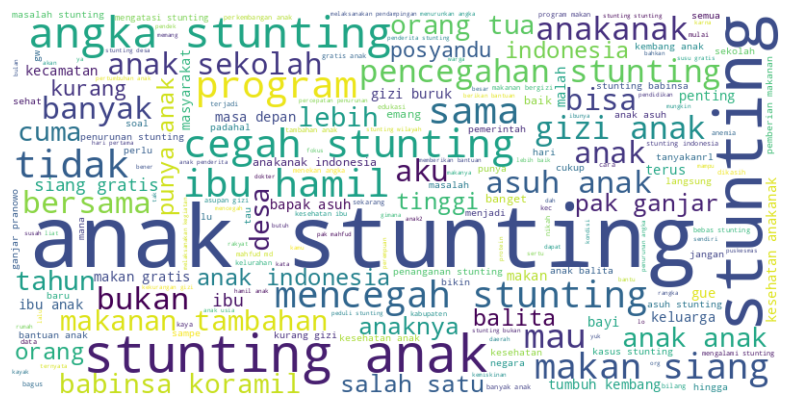

In [36]:
all_text = " ".join(tweet for tweet in df_cleaned)

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
new_texts = df_cleaned
new_texts

In [38]:
new_inputs, new_masks = tokenize_data(new_texts, tokenizer)
new_inputs = new_inputs.to(device)
new_masks = new_masks.to(device)

In [39]:
new_data_dataset = TensorDataset(new_inputs, new_masks)
new_data_loader = DataLoader(new_data_dataset, batch_size=batch_size, shuffle=False)

# Initialize list for storing predictions
all_predictions = []
label_mapping = {1: 'negative', 0: 'neutral', 2: 'positive'}

# Predict in batches
for batch in new_data_loader:
    b_input_ids, b_input_mask = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model(b_input_ids, b_input_mask)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    all_predictions.extend(predictions)

# Convert predictions to labels
predicted_labels = [label_mapping[p] for p in all_predictions]


In [40]:
final_data = pd.DataFrame({'full_text': df_cleaned, 'sentiment': predicted_labels})
final_data

,full_text,sentiment
0,tanyakanrl halo semuanya memiliki project stun...,neutral
1,gerakan bapak asuh anak stunting dandim 1418ma...,neutral
2,kolaborasi 3 pilar memberikan bantuan anak men...,neutral
3,permasalahan stunting terjadi mulai dalam kand...,neutral
4,1 stunting hingga kini menjadi masalah serius ...,negative
...,...,...
6021,yuk perhatikan pola asuh kandungan gizi makana...,neutral
6022,daddyminussugar recehtapisayng eh aku segitu t...,negative
6023,ah ide trus tar status gizi anak misal anak 2t...,negative
6024,schfess bukannya stunting dicegah sejak 1000 h...,negative


In [41]:
final_data['sentiment'].value_counts()

sentiment
neutral     3273
negative    2176
positive     577
Name: count, dtype: int64

In [42]:
final_data.to_csv('predicted-ms.csv', index=False)

## **LDA**

In [ ]:
lda_dataset = pd.read_csv('/kaggle/input/lda-dataset/predicted-sentiment.csv')

In [ ]:
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

custom_stopwords = ["nya", "yg", "jg", 'aja', 'utk', 'di', 'dgn', 'tp', 'lah', 'jd', 'udh', 'pa', 'amp', 'bgt', 'krn'
                   'tuh', 'kan', 'krn', 'klo', 'sih', 'apa', 'yang', 'kalo', 'biar', 'untuk', 'dr', 'juga', 'itu', 'si', 'tau'
                   'yang', 'kok', 'ada','nih', 'doang', 'gitu', 'udah', 'tuh', 'ini', 'pas', 'jadi', 'tu', 'sdh', 'trs', 'kek',
                   'melalui', 'buat' 'kalau', 'yes', 'nah', 'kalau', 'pake', 'buat', 'dulu', 'gpmmd', 'gpmmd 4palu', 'gpmmd 4donggala'
                   'carafitnahkelautaja', 'masbowogibran', '4donggala', '4palu', 'dg', 'loh', '4kupang', 'mah', 'gini', 'kl', 'deh', 
                    '4kupang', 'stunting', 'mencegah stunting', 'pencegahan stunting', 'penurunan', 'penanganan', 'indonesia', 'atasi', 'cegah', 'stunting indonesia',
                    'program stunting', 'salah satu', 'penurunan stunting', 'melalui program', 'program', 'mencegah', 'anak', 'anakanak', 'pak ganjar', 'ganjar pranowo', 'ganjar',
                    'pranowo', 'pak', "saya", 'gua', 'gw', 'aku', 'lu', 'sy', 'gue', 'semua', 'sama', 'cuma' 'salah satu', 'salah', 'satu', 'gw', 'bagus',
                    'ganjar pranowo', 'bukan', 'banget', 'pencegahan', 'prabowo', 'carafitnahkelautaja', 'efekdahsyat makangratis', 'efekdahsyat', 'ganjarmahfud',
                    'emg', 'punya', 'ganjarpranowo', 'cuma', 'upaya', 'menurunkan angka', 'menurunkan', 'angka', 'menekan angka', 'lebih baik',
                    'ganjarmahfud2024', 'mahfud md', 'mahfud', 'md', 'emang', '3mandatganjarmahfud l3bihbaik', 'mau', '3mandatganjarmahfud', 'nikamtul_sg',
                    'l3bihbaik', 'dulujokowisekarangganjar coblos3', 'dulujokowisekarangganjar', 'coblos3', 'coblos3 sukses', 'ganjarmahfudm3nangdebat',
                    'pranowoprof']

def preprocess_text(text, custom_stopwords):
    # Ensure text is stripped and extra spaces are removed
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove punctuation and lowercase text
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Change 'ga' and 'gak' to 'tidak'
    text = re.sub(r'\btdk\b', 'tidak', text)
    text = re.sub(r'\bngga\b', 'tidak', text)
    text = re.sub(r'\bgk\b', 'tidak', text) 
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    # Remove Sastrawi stopwords
    text = stopword_remover.remove(text)
    # Remove custom stopwords
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

def clean_tweet(tweet):
    # Replace URLs with a common token
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Replace mentions with a common token
    #tweet = re.sub(r'@\w+', '@USER', tweet)
    # Optionally normalize hashtags (comment out if you want to keep them as is)
    #tweet = re.sub(r'#\w+', '#HASHTAG', tweet)
    # Remove special characters and extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

emojis = {':)': 'senyum', ':-)': 'senyum', ';d': 'mengedipkan mata', ':-E': 'vampir', ':(': 'sedih', 
          ':-(': 'sedih', ':-<': 'sedih', ':P': 'meledek', ':O': 'kaget',
          ':-@': 'kaget', ':@': 'kaget',':-$': 'bingung', ':\\': 'kesal', 
          ':#': 'diam', ':X': 'diam', ':^)': 'senyum', ':-&': 'bingung', '$_$': 'rakus',
          ':-!': 'bingung', ':-D': 'senyum', ':-0': 'berteriak', 'O.o': 'bingung',
          '<(-_-)>': 'robot', 'd[-_-]b': 'ok', ';)': 'mengedipkan mata', 
          ';-)': 'mengedipkan mata',}

def replace_emojis(tweet):
    for emoji, replacement in emojis.items():
        tweet = tweet.replace(emoji, replacement)
    return tweet

def lower_case(text):  
    text = text.lower()
    return text

In [ ]:
lda_dataset

In [ ]:
lda_dataset['full_text'] = lda_dataset['full_text'].apply(clean_tweet)
lda_dataset['full_text'] = lda_dataset['full_text'].apply(lambda x: preprocess_text(x, custom_stopwords))
lda_dataset['full_text'] = lda_dataset['full_text'].apply(replace_emojis)
lda_dataset['full_text'] = lda_dataset['full_text'].apply(lower_case)

In [ ]:
lda_dataset['sentiment'].value_counts()

In [ ]:
all_text = " ".join(tweet for tweet in lda_dataset['full_text'])

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
positive_opinion = lda_dataset[lda_dataset['sentiment'] == 'positive']
negative_opinion = lda_dataset[lda_dataset['sentiment'] == 'negative']
neutral_opinion = lda_dataset[lda_dataset['sentiment'] == 'neutral']

In [ ]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

wc_text_pos = positive_opinion['full_text'].apply(lambda x: preprocess_wc(x, wc_list))

all_text_pos = " ".join(tweet for tweet in wc_text_pos)

wordcloud = WordCloud(background_color="white", width=800, height=500).generate(
    all_text_pos
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wc_text_neu = neutral_opinion['full_text'].apply(lambda x: preprocess_wc(x, wc_list))

all_text_neu = " ".join(tweet for tweet in wc_text_neu)

wordcloud = WordCloud(background_color="white", width=800, height=500).generate(
    all_text_neu
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wc_text_neg = negative_opinion['full_text'].apply(lambda x: preprocess_wc(x, wc_list))

all_text_neg = " ".join(tweet for tweet in wc_text_neg)

wordcloud = WordCloud(background_color="white", width=800, height=500).generate(
    all_text_neg
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Positive Opinion Word Cloud
all_text_positive = " ".join(tweet for tweet in wc_text_pos)
wordcloud_positive = WordCloud(background_color="white", width=400, height=200).generate(all_text_positive)

# Negative Opinion Word Cloud
all_text_negative = " ".join(tweet for tweet in wc_text_neg)
wordcloud_negative = WordCloud(background_color="white", width=400, height=200).generate(all_text_negative)

# Neutral Opinion Word Cloud
all_text_neutral = " ".join(tweet for tweet in wc_text_neu)
wordcloud_neutral = WordCloud(background_color="white", width=400, height=200).generate(all_text_neutral)

# Plotting Side by Side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Positive Opinion
axes[0].imshow(wordcloud_positive, interpolation="bilinear")
axes[0].set_title('Positive Opinion')
axes[0].axis("off")

# Negative Opinion
axes[1].imshow(wordcloud_negative, interpolation="bilinear")
axes[1].set_title('Negative Opinion')
axes[1].axis("off")

# Neutral Opinion
axes[2].imshow(wordcloud_neutral, interpolation="bilinear")
axes[2].set_title('Neutral Opinion')
axes[2].axis("off")

plt.tight_layout()
plt.show()


## **Negative LDA**

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

negative_text = negative_opinion['full_text']

factory = StemmerFactory()
stemmer = factory.create_stemmer()

neg_stemmed_texts = [" ".join([stemmer.stem(word) for word in text.split()]) for text in negative_text]
neg_stemmed_texts = [text for text in neg_stemmed_texts if text.strip() != ""]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
neg_X = vectorizer.fit_transform(neg_stemmed_texts)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(neg_X)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

## **Positive LDA**

In [ ]:
positive_text = positive_opinion['full_text']

factory = StemmerFactory()
stemmer = factory.create_stemmer()

pos_stemmed_texts = [" ".join([stemmer.stem(word) for word in text.split()]) for text in positive_text]
pos_stemmed_texts = [text for text in pos_stemmed_texts if text.strip() != ""]

In [ ]:
vectorizer = CountVectorizer()
pos_X = vectorizer.fit_transform(pos_stemmed_texts)

In [ ]:
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(pos_X)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

## **Neutral LDA**

In [ ]:
neutral_text = neutral_opinion['full_text']

factory = StemmerFactory()
stemmer = factory.create_stemmer()

neu_stemmed_texts = [" ".join([stemmer.stem(word) for word in text.split()]) for text in neutral_text]
neu_stemmed_texts = [text for text in neu_stemmed_texts if text.strip() != ""]

In [ ]:
vectorizer = CountVectorizer()
neu_X = vectorizer.fit_transform(neu_stemmed_texts)

In [ ]:
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(neu_X)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))